In [9]:
#import packages
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean
from collections import defaultdict
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

final = pd.read_csv("../raw_data/track_meta_milestone3.csv", index_col="Unnamed: 0") #read data

In [12]:
final_new = final[['Playlistid', 'Trackid', 'Artist_Name', 'Track_uri',
                   'Track_Name', 'Album_Name', 'Track_Duration',
                   'acousticness', 'artist_genres', 'artist_popularity',
                   'danceability', 'energy', 'instrumentalness', 'key',
                   'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
                   'time_signature', 'valence']] #keep columns of interest

In [13]:
len(final_new.Playlistid.unique()) #check how many unique playlist is included

27016

## Train-Test Split

In [15]:
## Train-Test Split
# Train-val-test split (20%)
train, test = train_test_split(final_new, test_size=0.2, random_state=48, stratify = final_new['Playlistid'])
train, val = train_test_split(train, test_size=0.2, random_state=48, stratify = train['Playlistid'])

In [16]:
train['index'] = np.arange(1, len(train)+1) #append index column for merging scaled data

## Scale Features for Clustering

In [18]:
scaleCols = ['acousticness', 'danceability', 'energy', 'instrumentalness',
             'key', 'liveness', 'loudness', 'speechiness', 'tempo','valence', 'time_signature', 'artist_popularity'] #mode excluded from analysis
scaler = StandardScaler()
scaler.fit(train.loc[:, scaleCols])
train_scaled = train.copy() #copy original master data frame
train_scaled[scaleCols] = scaler.transform(train_scaled[scaleCols]) #scale transform cluster columns
train_scaled['index'] = np.arange(1, len(train_scaled)+1) #reappend index column
train_scaled = train_scaled.rename(columns = {'acousticness': 'acousticness_scaled',
                                              'danceability': 'danceability_scaled',
                                              'energy': 'energy_scaled',
                                              'instrumentalness': 'instrumentalness_scaled',
                                              'key': 'key_scaled',
                                              'liveness': 'liveness_scaled',
                                              'loudness': 'loudness_scaled',
                                              'speechiness': 'speechiness_scaled',
                                              'tempo': 'tempo_scaled',
                                              'valence': 'valence_scaled',
                                              'time_signature': 'time_signature_scaled',
                                              'artist_popularity': 'artist_popularity_scaled'})
joinCols = ['index', 'Playlistid', 'Trackid', 'Track_uri', 'Artist_Name',
            'Track_Name', 'Album_Name', 'Track_Duration', 
            'artist_genres', 'mode']
train_new = train.merge(train_scaled, on = joinCols, how = 'outer') #merge scaled data with original data

## Optimal K

In [19]:
clusterCols = ['acousticness_scaled','danceability_scaled', 
               'energy_scaled', 'instrumentalness_scaled',
               'key_scaled', 'liveness_scaled', 'loudness_scaled',
               'speechiness_scaled', 'tempo_scaled', 'time_signature_scaled',
               'valence_scaled','artist_popularity_scaled'] #variables to cluster
train_new[clusterCols].corr() #check correlations between variables

,acousticness_scaled,danceability_scaled,energy_scaled,instrumentalness_scaled,key_scaled,liveness_scaled,loudness_scaled,speechiness_scaled,tempo_scaled,time_signature_scaled,valence_scaled,artist_popularity_scaled
acousticness_scaled,1.000000,-0.193022,-0.564649,0.130967,-0.014914,-0.074127,-0.478663,-0.029449,-0.105691,-0.154035,-0.147618,-0.123297
danceability_scaled,-0.193022,1.000000,-0.011284,-0.125954,-0.029260,-0.103919,0.124124,0.199178,-0.146080,0.134505,0.286457,0.161664
energy_scaled,-0.564649,-0.011284,1.000000,-0.103263,0.048788,0.164393,0.725221,-0.067180,0.138223,0.146355,0.396371,-0.019070
instrumentalness_scaled,0.130967,-0.125954,-0.103263,1.000000,-0.007510,-0.006142,-0.249167,-0.084523,-0.009040,-0.055936,-0.110724,-0.185251
key_scaled,-0.014914,-0.029260,0.048788,-0.007510,1.000000,-0.002062,0.030495,0.015519,0.025369,0.000127,0.028369,-0.001916
liveness_scaled,-0.074127,-0.103919,0.164393,-0.006142,-0.002062,1.000000,0.082565,0.093733,0.042035,0.007835,0.019599,-0.000871
loudness_scaled,-0.478663,0.124124,0.725221,-0.249167,0.030495,0.082565,1.000000,-0.047323,0.104824,0.127370,0.234421,0.132596
speechiness_scaled,-0.029449,0.199178,-0.067180,-0.084523,0.015519,0.093733,-0.047323,1.000000,0.095750,0.039497,-0.024659,0.181152
tempo_scaled,-0.105691,-0.146080,0.138223,-0.009040,0.025369,0.042035,0.104824,0.095750,1.000000,-0.007684,0.016971,0.004881
time_signature_scaled,-0.154035,0.134505,0.146355,-0.055936,0.000127,0.007835,0.127370,0.039497,-0.007684,1.000000,0.091962,0.059657


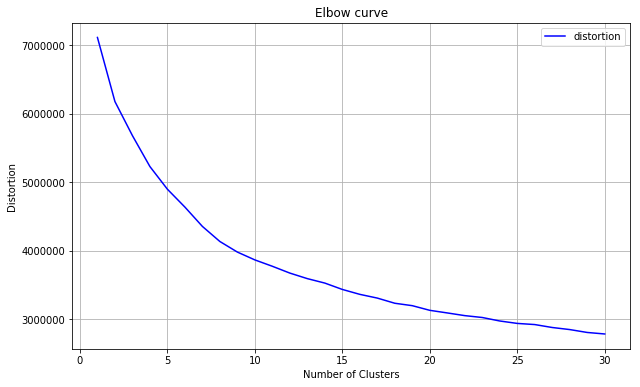

In [20]:
clusterCols = ['acousticness_scaled','danceability_scaled', 
               'energy_scaled', 'instrumentalness_scaled',
               'key_scaled', 'liveness_scaled', 'loudness_scaled',
               'speechiness_scaled', 'tempo_scaled', 'time_signature_scaled',
               'valence_scaled', 'artist_popularity_scaled'] #variables to cluster

distortion = list()
for k in range(1, 31): #experiment with k in [1,30]
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(train_new.loc[:, clusterCols])
    distortion.append(kmeans.inertia_) #append distortion value to list

#plot elbow curves 
fig = plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), distortion, c = 'b', label = 'distortion')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.legend()
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [21]:
#initiate clusters
def makeCluster(df, n, rs, cols):
    '''
    Parameters:
    1) df: master data frame
    2) n: number of clusters
    3) rs: random state
    4) cols: list of clustering variables
    '''
    #copy dataframe
    dfCluster = df.copy()

    #fit clusters
    kmeans = KMeans(n_clusters = n, random_state = rs)
    kmeans.fit(dfCluster.loc[:, cols])

    #get location of cluster centroids and label
    center = kmeans.cluster_centers_
    label = kmeans.labels_
    dfCluster['cluster_label'] = label
    dfCluster['cluster_label'] = dfCluster['cluster_label'] + 1 #increment by 1 so 0 implies non-existence in prediction
    
    #append centroids to data frame
    centroids = defaultdict(list)
    for col in cols:
        centroids['columns'].append(col)
    for a in range(len(center)):
        for b in range(len(center[0])):
            centroids['c'+ str(a)].append(center[a][b])
            dfCluster['c'+ str(a) + cols[b]] = center[a][b]

    return dfCluster, pd.DataFrame.from_dict(centroids)

In [22]:
#train cluster
train_cluster, train_centroids = makeCluster(train_new, 8, 48, clusterCols)

In [24]:
#rank centroids
def rankC(dfCentroid, n):
    rankC = defaultdict(list)
    for i in range(n):
        rankC['cluster'].append(i)
        for j in range(n):
            rankC[str(j)].append(euclidean(dfCentroid['c'+str(i)], dfCentroid['c'+str(j)]))    
    rankC = pd.DataFrame(rankC)
    orderRankC = defaultdict(list)
    for i in range(n):
        orderRankC[str(i)] = rankC[str(i)].sort_values(ascending = True).index.values
    return orderRankC

orderRankc = rankC(train_centroids, 8)

In [25]:
#initialize prediction cluster
prediction_cluster = train_cluster[['Playlistid', 'Trackid', 'Track_uri', 'Artist_Name', 'Track_Name',
                                   'artist_genres','artist_popularity', 'cluster_label']]

In [26]:
#compute the times an artist appears in one cluster
mode_artist = prediction_cluster.groupby(['cluster_label', 'Artist_Name'])['Playlistid'].count().reset_index()
mode_artist = mode_artist.rename(columns = {'Playlistid': 'mode_artist'})
prediction_cluster = prediction_cluster.merge(mode_artist, on = ['cluster_label', 'Artist_Name'])

In [27]:
#compute the times a track appears in one cluster
mode_track = prediction_cluster.groupby(['cluster_label', 'Track_Name'])['Playlistid'].count().reset_index()
mode_track = mode_track.rename(columns = {'Playlistid': 'mode_track'})
prediction_cluster = prediction_cluster.merge(mode_track, on = ['cluster_label', 'Track_Name'])

## Prediction

In [28]:
#this code corresponds to the original model, which is defined in predict_cluster.py
def nholdout(playlist_id, df):
    '''Pass in a playlist id to get number of songs held out in val/test set'''
    
    return len(df[df.Playlistid == playlist_id].Track_uri)

def cPredict(dfCluster, playlist_id, clusterRank, df):
    
    k = nholdout(playlist_id, df)*15 #number of predictions
    pred = list() #cache list for prediction

    playlist = dfCluster[dfCluster['Playlistid'] == playlist_id] #get playlist from cluster data frame
    tracks = playlist.Track_uri.values #list of existing tracks
    
    #get cluster label count from playlist
    clusterCNT = playlist.groupby('cluster_label').agg({
    'Playlistid': len
    }).reset_index().sort_values(by = 'Playlistid', ascending = False) 
    
    #cluster labels order by occurance in descending order
    labels = clusterCNT.cluster_label.values.tolist()
    
    #populate cluster labels based on computed euclidean distances 
    for label in labels:
        add = clusterRank[str(label)]
        for c in add:
            if c not in labels:
                labels.append(c)       
    
    #predict based on cluster popularity
    for label in labels:      
        fit = dfCluster[dfCluster['cluster_label'] == label] #subset tracks with the same label
        rankTrack = fit.sort_values(by = ['mode_artist','mode_track'], ascending = [False,False]) #rank tracks in fit by artist and track
        pred_uri = rankTrack.Track_uri.values
        for uri in pred_uri:
            if uri not in tracks:
                pred.append(uri)
                if len(pred) == k:
                    break
            if len(pred) == k:
                break
        if len(pred) == k:
            break
    
    return pred

## Performance

In [29]:
def r_precision(prediction, val_set):
# prediction should be a list of predictions
# val_set should be pandas Series of ground truths
    score = np.sum(val_set.isin(prediction))/val_set.shape[0]
    return score

### NDCG Code Source: https://gist.github.com/bwhite/3726239
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [39]:
#validation check
rps = []
ndcgs = []
count = 1
for pid in val.Playlistid.unique():
    #track progress
    if count%100 == 0:
        print(count)
    ps = cPredict(prediction_cluster, pid, orderRankc, val) # predictions
    vs = val[val.Playlistid == pid].Track_uri # ground truth
    rps.append(r_precision(ps, vs))
    
    r = np.zeros(len(ps))
    for i, p in enumerate(ps):
        if np.any(vs.isin([p])):
            r[i] = 1
    ndcgs.append(ndcg_at_k(r, len(r)))
    count += 1

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [42]:
avg_rp = np.mean(rps)
avg_ndcg = np.mean(ndcgs)
print('Avg. R-Precision: ', avg_rp)
print('Avg. NDCG: ', avg_ndcg)
print('Total Sum: ', np.mean([avg_rp, avg_ndcg]))

Avg. R-Precision:  0.0038221023396255065
Avg. NDCG:  0.01917429444932553
Total Sum:  0.011498198394475518


In [55]:
import predict_cluster_updated #import updated model

In [58]:
#test check
rps_updated = []
ndcgs_updated = []
count = 1
for pid in test.Playlistid.unique():
    #track progress
    if count%100 == 0:
        print(count)
    ps = predict_cluster_updated.cPredict(prediction_cluster, pid, orderRankc, test) # predictions
    vs = test[test.Playlistid == pid].Track_uri # ground truth
    rps_updated.append(r_precision(ps, vs))
    
    r = np.zeros(len(ps))
    for i, p in enumerate(ps):
        if np.any(vs.isin([p])):
            r[i] = 1
    ndcgs_updated.append(ndcg_at_k(r, len(r)))
    count += 1

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [59]:
avg_rp_updated = np.mean(rps_updated)
avg_ndcg_updated = np.mean(ndcgs_updated)
print('Avg. R-Precision: ', avg_rp_updated)
print('Avg. NDCG: ', avg_ndcg_updated)
print('Total Sum: ', np.mean([avg_rp_updated, avg_ndcg_updated]))

Avg. R-Precision:  0.11920621703867183
Avg. NDCG:  0.1326935728997349
Total Sum:  0.12594989496920336
